In [5]:
%load_ext autoreload
%autoreload 2
import torch
import numpy as np
import pandas as pd
from omegaconf import OmegaConf
from pathlib import Path
from pprint import pprint
# plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
# mycode
from repo import REPO
from ml_utilities.output_loader.job_output import SweepResult, JobResult
from ml_utilities.output_loader import create_job_output_loader
from ml_utilities.output_loader.plot import plot_sweep_summary, plot_data_log_values

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 11.7.4 MNIST LeNet rotatedtasks finetune

**RERUN 11.7.3**: use less samples for finetuning = 50

- This is the follow up experiment for my PhD Talk
- Sweep over number of pretraining steps on rotation 0 (with 48k samples)
- Finetune rotations between 0°-180° (linspace(0,180,30,endpoint=True)) with limited number of samples (50)

Make the following investigations:
1. Plot pre-train length (x-axis) vs. val-accuracy (y-axis) for different rotations
2. Check linear mode connectivity of fine-tuning runs for different rotations

## A. Experiment config

### Config file

In [6]:
config_yaml = """
run_config:
  exec_type: parallel # sequential
  hostname: wasp
  gpu_ids: [0,1,2,3,4]
  runs_per_gpu: 5

  wandb: # wandb config for run_handler, if "wandb: null" then logging to wandb is disabled for run_handler
    init:
      tags:
        - ${config.experiment_data.experiment_tag}_exps
        - run_handler
      notes: #
      group: ${config.experiment_data.experiment_tag}
      job_type: run_handler

seeds: [1,2]

sweep:
  type: grid
  axes:
    - parameter: trainer.init_model_step
      vals: [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475]
    - parameter: data.dataset_kwargs.rotation_angle
      vals: linspace(0,180,30,endpoint=True)
    - parameter: data.dataset_split.restrict_n_samples_train_task
      vals: [50] #[5, 20, 50, 100, 500, 1000, 10000, 48000]

start_num: 4 # use this to count how often this config is run
###
config:
  experiment_data:
    entity: jkuiml-fsl
    project_name: sparsity
    experiment_tag: "11.7"
    experiment_type: startnum_${start_num}
    experiment_name: mnist-${config.experiment_data.experiment_tag}.${start_num}-lenet_rottasks_ft
    experiment_dir: null
    experiment_notes: Hyperparameter search.
    job_name: null
    seed: 0
    hostname: null # the server on which the run is run, will be filled by run_handler
    gpu_id: 0

  # wandb:
  #   init:
  #     tags: # list(), used to tag wandblogger
  #       - ${config.experiment_data.experiment_tag}_exps
  #     notes: ${config.experiment_data.experiment_notes} # str, used to make notes to wandblogger
  #     group: ${config.experiment_data.experiment_tag} # null
  #     job_type: ${config.experiment_data.experiment_type} # examples: hypsearch, pretrain, eval, etc.

  #   watch:
  #     log: null #parameters #null #all
  #     log_freq: 5000

  model:
    name: fc
    model_kwargs:
      input_size: 784
      hidden_sizes:
        - 300
        - 100
      output_size: 10
      flatten_input: True
      dropout: null
      act_fn: relu

  trainer:
    training_setup: supervised
    n_steps: 2000
    log_train_step_every: 1
    log_additional_train_step_every_multiplier: 1
    log_additional_logs: True
    val_every: 5
    save_every: 5 #500
    early_stopping_patience: 200 #500
    batch_size: 128
    optimizer_scheduler:
      optimizer_name: adamw #sgd #adamw
      optimizer_kwargs:
        lr: 0.001
        weight_decay: 0.0
    
    init_model_step: XXX
    init_model: /system/user/beck/pwbeck/projects/regularization/erank/outputs/mnist-11.5.0-lenet--221015_122552/model_step_${config.trainer.init_model_step}.p

    loss: crossentropy

    metrics:
      - Accuracy
    num_workers: 4
    verbose: False

  data:
    dataset: rotatedvision
    dataset_kwargs:
      data_root_path: /system/user/beck/pwbeck/data
      dataset: mnist
      rotation_angle: XXX
    dataset_split:
      train_val_split: 0.8
      restrict_n_samples_train_task: XXX

"""
cfg = OmegaConf.create(config_yaml)

In [7]:
run_command = REPO.create_experiment(cfg, override=False)
print(run_command)

python run_sweep.py --config-name mnist-11.7.4-lenet_rottasks_ft.yaml


### Sweep result

In [6]:
sweepr = REPO.get_output_loader(cfg)
print(sweepr)

Exp. Tag(start_num): 11.7(3)
Exp. Name: mnist-11.7.3-lenet_rottasks_ft
Training setup: supervised
Model name: fc
Dataset name: rotatedvision
Sweep type: grid
  trainer.init_model_step: [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475]
  data.dataset_kwargs.rotation_angle: linspace(0,180,50,endpoint=True)
  data.dataset_split.restrict_n_samples_train_task: [300]
Num. jobs: 5400
Config updated: 2022-11-25 12:34:14
Sweep started:  2022-11-25 12:36:51



### Helper variables from config

In [7]:
# some important variables from config
pretrain_run = JobResult(job_dir=Path(cfg.config.trainer.init_model).parent)

In [8]:
pretrain_run.get_summary()

,best_step,best_val_score,seed
mnist-11.5.0-lenet--221015_122552,430,0.96075,0


## B. Pretrain length vs. Finetune-val-accuracy

In [9]:
print(sweepr)

Exp. Tag(start_num): 11.7(3)
Exp. Name: mnist-11.7.3-lenet_rottasks_ft
Training setup: supervised
Model name: fc
Dataset name: rotatedvision
Sweep type: grid
  trainer.init_model_step: [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475]
  data.dataset_kwargs.rotation_angle: linspace(0,180,50,endpoint=True)
  data.dataset_split.restrict_n_samples_train_task: [300]
Num. jobs: 5400
Config updated: 2022-11-25 12:34:14
Sweep started:  2022-11-25 12:36:51



In [10]:
# failed_jobs = sweepr.get_failed_jobs()
# failed_jobs # No failed jobs

In [24]:
pprint(sweepr.available_log_columns)

{'_common_cols': ['epoch', 'train_step', 'log_step'],
 'train': ['Accuracy', 'loss_CrossEntropyLoss', 'time_last_train_epoch_in_s'],
 'train_step': ['Accuracy', 'loss_CrossEntropyLoss', 'weight_norm'],
 'val': ['Accuracy', 'loss_CrossEntropyLoss', 'time_last_val_epoch_in_s']}


In [25]:
sw_summary = sweepr.get_summary()

100%|██████████| 5400/5400 [02:42<00:00, 33.23it/s]


In [29]:
sw_summary = sw_summary.sort_values(by=['trainer.init_model_step', 'data.dataset_kwargs.rotation_angle'])

In [30]:
sw_summary

,best_step,best_val_score,trainer.init_model_step,data.dataset_kwargs.rotation_angle,data.dataset_split.restrict_n_samples_train_task,seed
mnist-11.7.3-lenet_rottasks_ft--init_model_step-0-rotation_angle-0-restrict_n_samples_train_task-300-seed-1--221126_002056,110,0.844417,0,0.000000,300,1
mnist-11.7.3-lenet_rottasks_ft--init_model_step-0-rotation_angle-0-restrict_n_samples_train_task-300-seed-2--221126_065442,160,0.842333,0,0.000000,300,2
mnist-11.7.3-lenet_rottasks_ft--init_model_step-0-rotation_angle-0-restrict_n_samples_train_task-300-seed-3--221128_011414,90,0.843500,0,0.000000,300,3
mnist-11.7.3-lenet_rottasks_ft--init_model_step-0-rotation_angle-3.67347-restrict_n_samples_train_task-300-seed-1--221127_112533,110,0.850417,0,3.673469,300,1
mnist-11.7.3-lenet_rottasks_ft--init_model_step-0-rotation_angle-3.67347-restrict_n_samples_train_task-300-seed-2--221128_003316,160,0.847500,0,3.673469,300,2
...,...,...,...,...,...,...
mnist-11.7.3-lenet_rottasks_ft--init_model_step-475-rotation_angle-176.327-restrict_n_samples_train_task-300-seed-2--221127_103444,1740,0.865000,475,176.326531,300,2
mnist-11.7.3-lenet_rottasks_ft--init_model_step-475-rotation_angle-176.327-restrict_n_samples_train_task-300-seed-3--221127_144808,1945,0.865333,475,176.326531,300,3
mnist-11.7.3-lenet_rottasks_ft--init_model_step-475-rotation_angle-180-restrict_n_samples_train_task-300-seed-1--221125_172410,1835,0.861417,475,180.000000,300,1
mnist-11.7.3-lenet_rottasks_ft--init_model_step-475-rotation_angle-180-restrict_n_samples_train_task-300-seed-2--221127_173536,1940,0.863500,475,180.000000,300,2


In [38]:
sw_summary.groupby(by=['trainer.init_model_step','data.dataset_kwargs.rotation_angle']).mean()

best_step  \
trainer.init_model_step data.dataset_kwargs.rotation_angle                
0                       0.000000                             120.000000   
                        3.673469                             208.333333   
                        7.346939                             683.333333   
                        11.020408                            783.333333   
                        14.693878                            105.000000   
...                                                                 ...   
475                     165.306122                          1910.000000   
                        168.979592                          1975.000000   
                        172.653061                          1905.000000   
                        176.326531                          1885.000000   
                        180.000000                          1525.000000   

                                                            best_val_score  \
trainer.init_model_step data.dataset_kwargs.rotation_angle                   
0                       0.000000                                  0.843417   
                        3.673469                                  0.849722   
                        7.346939                                  0.852389   
                        11.020408                                 0.850250   
                        14.693878                                 0.850472   
...                                                                    ...   
475                     165.306122                                0.867556   
                        168.979592                                0.866944   
                        172.653061                                0.864472   
                        176.326531                                0.865639   
                        180.000000                                0.862111   

                                                            data.dataset_split.restrict_n_samples_train_task  \
trainer.init_model_step data.dataset_kwargs.rotation_angle                                                     
0                       0.000000                                                                       300.0   
                        3.673469                                                                       300.0   
                        7.346939                                                                       300.0   
                        11.020408                                                                      300.0   
                        14.693878                                                                      300.0   
...                                                                                                      ...   
475                     165.306122                                                                     300.0   
                        168.979592                                                                     300.0   
                        172.653061                                                                     300.0   
                        176.326531                                                                     300.0   
                        180.000000                                                                     300.0   

                                                            seed  
trainer.init_model_step data.dataset_kwargs.rotation_angle        
0                       0.000000                             2.0  
                        3.673469                             2.0  
                        7.346939                             2.0  
                        11.020408                            2.0  
                        14.693878                            2.0  
...                                                          ...  
475                     165.306122                           2.0  
           

In [107]:
pv_df = sw_summary[sw_summary['seed']==2]
pv_df

,best_step,best_val_score,trainer.init_model_step,data.dataset_kwargs.rotation_angle,data.dataset_split.restrict_n_samples_train_task,seed
mnist-11.7.3-lenet_rottasks_ft--init_model_step-0-rotation_angle-0-restrict_n_samples_train_task-300-seed-2--221126_065442,160,0.842333,0,0.000000,300,2
mnist-11.7.3-lenet_rottasks_ft--init_model_step-0-rotation_angle-3.67347-restrict_n_samples_train_task-300-seed-2--221128_003316,160,0.847500,0,3.673469,300,2
mnist-11.7.3-lenet_rottasks_ft--init_model_step-0-rotation_angle-7.34694-restrict_n_samples_train_task-300-seed-2--221126_010002,1810,0.854167,0,7.346939,300,2
mnist-11.7.3-lenet_rottasks_ft--init_model_step-0-rotation_angle-11.0204-restrict_n_samples_train_task-300-seed-2--221128_005237,930,0.851750,0,11.020408,300,2
mnist-11.7.3-lenet_rottasks_ft--init_model_step-0-rotation_angle-14.6939-restrict_n_samples_train_task-300-seed-2--221126_105614,105,0.850417,0,14.693878,300,2
...,...,...,...,...,...,...
mnist-11.7.3-lenet_rottasks_ft--init_model_step-475-rotation_angle-165.306-restrict_n_samples_train_task-300-seed-2--221127_193141,1885,0.869000,475,165.306122,300,2
mnist-11.7.3-lenet_rottasks_ft--init_model_step-475-rotation_angle-168.98-restrict_n_samples_train_task-300-seed-2--221128_003736,1995,0.868333,475,168.979592,300,2
mnist-11.7.3-lenet_rottasks_ft--init_model_step-475-rotation_angle-172.653-restrict_n_samples_train_task-300-seed-2--221126_224659,1855,0.862833,475,172.653061,300,2
mnist-11.7.3-lenet_rottasks_ft--init_model_step-475-rotation_angle-176.327-restrict_n_samples_train_task-300-seed-2--221127_103444,1740,0.865000,475,176.326531,300,2


### Rotation angle vs. Acc

In [108]:
rot_df = pv_df[pv_df['trainer.init_model_step']==100].sort_values(by='data.dataset_kwargs.rotation_angle')

In [112]:
rot_df

,best_step,best_val_score,trainer.init_model_step,data.dataset_kwargs.rotation_angle,data.dataset_split.restrict_n_samples_train_task,seed
mnist-11.7.3-lenet_rottasks_ft--init_model_step-100-rotation_angle-0-restrict_n_samples_train_task-300-seed-2--221126_064717,0,0.913250,100,0.000000,300,2
mnist-11.7.3-lenet_rottasks_ft--init_model_step-100-rotation_angle-3.67347-restrict_n_samples_train_task-300-seed-2--221126_132409,0,0.908750,100,3.673469,300,2
mnist-11.7.3-lenet_rottasks_ft--init_model_step-100-rotation_angle-7.34694-restrict_n_samples_train_task-300-seed-2--221127_103518,20,0.901250,100,7.346939,300,2
mnist-11.7.3-lenet_rottasks_ft--init_model_step-100-rotation_angle-11.0204-restrict_n_samples_train_task-300-seed-2--221127_132745,20,0.894167,100,11.020408,300,2
mnist-11.7.3-lenet_rottasks_ft--init_model_step-100-rotation_angle-14.6939-restrict_n_samples_train_task-300-seed-2--221126_172454,55,0.887917,100,14.693878,300,2
mnist-11.7.3-lenet_rottasks_ft--init_model_step-100-rotation_angle-18.3673-restrict_n_samples_train_task-300-seed-2--221126_124658,875,0.883250,100,18.367347,300,2
mnist-11.7.3-lenet_rottasks_ft--init_model_step-100-rotation_angle-22.0408-restrict_n_samples_train_task-300-seed-2--221127_093121,470,0.878333,100,22.040816,300,2
mnist-11.7.3-lenet_rottasks_ft--init_model_step-100-rotation_angle-25.7143-restrict_n_samples_train_task-300-seed-2--221127_232024,515,0.874250,100,25.714286,300,2
mnist-11.7.3-lenet_rottasks_ft--init_model_step-100-rotation_angle-29.3878-restrict_n_samples_train_task-300-seed-2--221127_222435,1415,0.868583,100,29.387755,300,2
mnist-11.7.3-lenet_rottasks_ft--init_model_step-100-rotation_angle-33.0612-restrict_n_samples_train_task-300-seed-2--221127_122108,1410,0.867500,100,33.061224,300,2


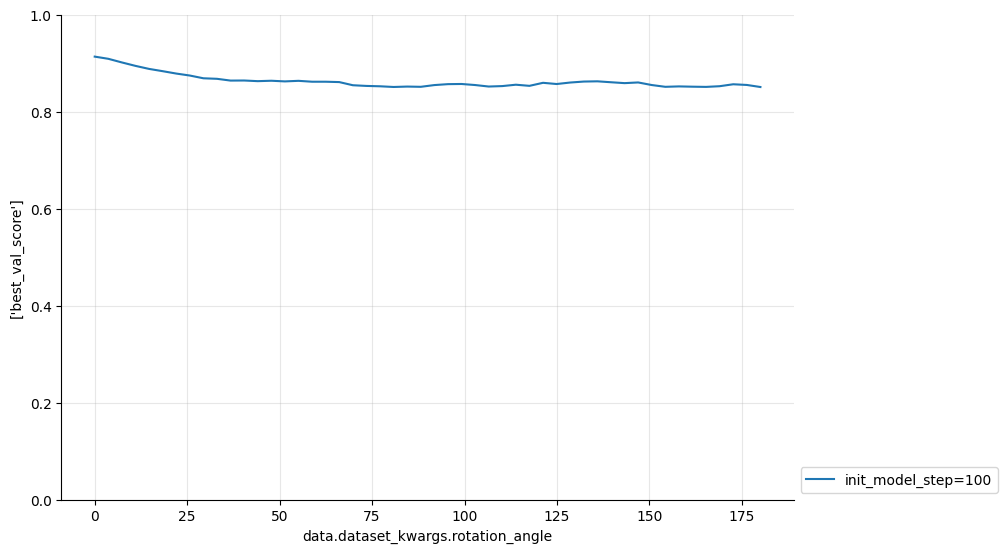

In [109]:
p0 = plot_sweep_summary(rot_df, x_axis='data.dataset_kwargs.rotation_angle', y_axis='best_val_score', compare_parameter='trainer.init_model_step', ylim=[0,1])

### Pretrain vs. [Acc, best_step]

We finetune a model pretrained on rotation 0° (48k samples) to other rotations 0°-180° (300 samples).
We use an early stopping patience of 200 steps (max. 2000).

Observations:
- more pretraining -> better final accuracy, even for large distribution shift (confirmed by low-level statistic obervation of neyshabur)
- the larger the distribution shift, the more fine-tuning steps are performed

In [110]:
compare_rotation_angles = np.linspace(0,180,50, endpoint=True)
cpvsel = list(compare_rotation_angles[0:1]) + list(compare_rotation_angles[1:20:3]) + list(compare_rotation_angles[-3::])
# cpvsel = [0., 180.]
cpvsel

[0.0,
 3.673469387755102,
 14.693877551020408,
 25.714285714285715,
 36.734693877551024,
 47.755102040816325,
 58.775510204081634,
 69.79591836734694,
 172.6530612244898,
 176.3265306122449,
 180.0]

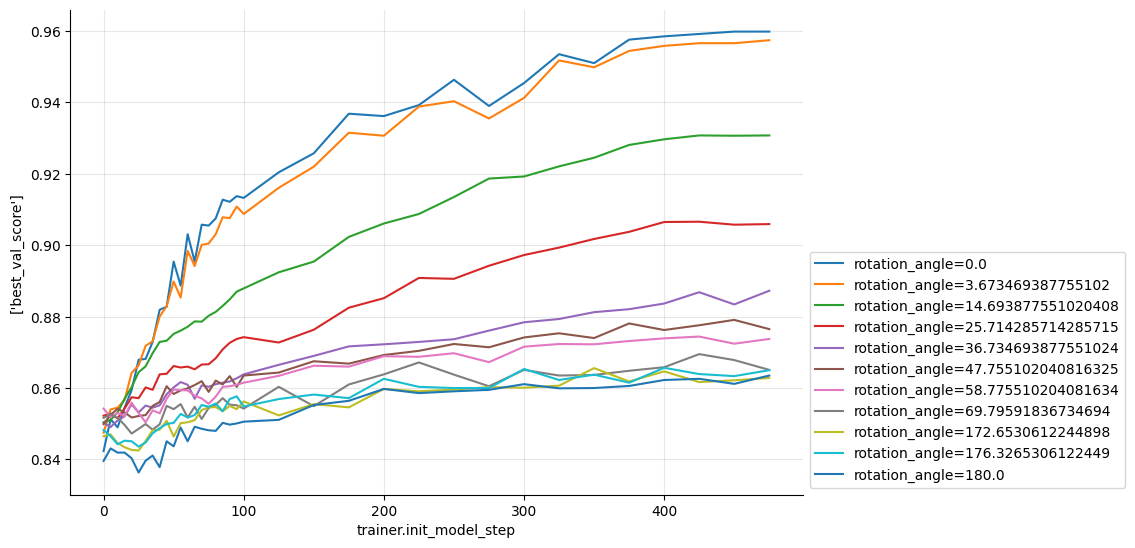

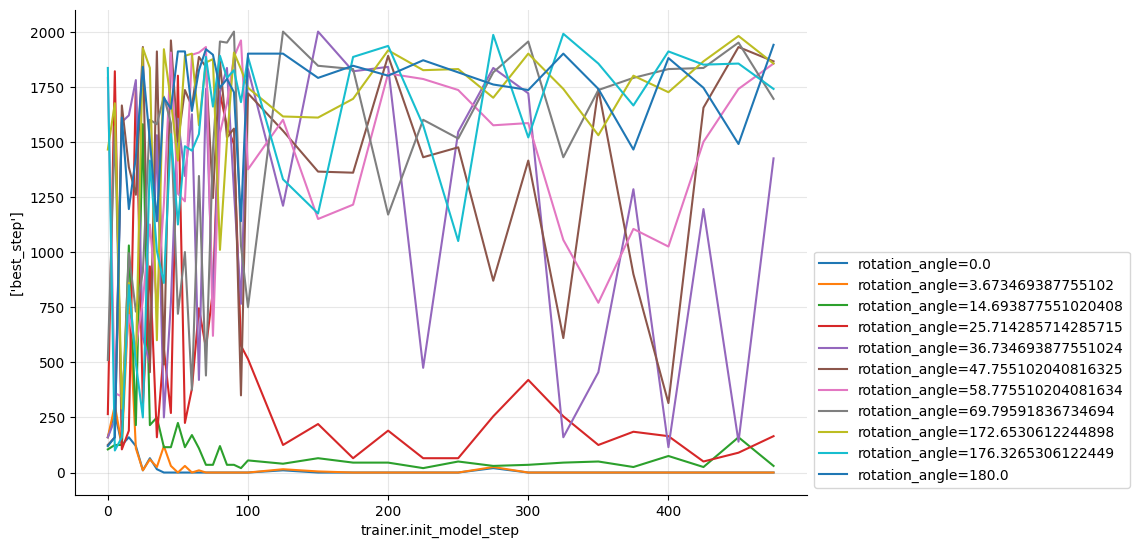

In [111]:
p1 = plot_sweep_summary(pv_df, x_axis='trainer.init_model_step', y_axis='best_val_score', compare_parameter='data.dataset_kwargs.rotation_angle', compare_parameter_val_selection=cpvsel)
p2 = plot_sweep_summary(pv_df, x_axis='trainer.init_model_step', y_axis='best_step', compare_parameter='data.dataset_kwargs.rotation_angle', compare_parameter_val_selection=cpvsel)

### Finetuning training curves